In [1]:
import os
import glob

from pathlib import Path
from itertools import groupby
from functools import lru_cache

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import math
import pandas as pd

from tqdm import tqdm

In [3]:
import re
from dataclasses import dataclass
from collections import defaultdict
from functools import cached_property

class Result:
    def __init__(self, output_dir: Path):
        conf_file = list(output_dir.glob('*.conf'))[0]
        log_file = [path for path in output_dir.glob("*.log") if not path.name.startswith("tetrisched_")][0]
        csv_file = [path for path in output_dir.glob("*.csv") if not path.name.startswith("libtetrisched_")][0]
        
        self.config = self._parse_config_file(conf_file)
        self.events = self._parse_csv_file(csv_file)
        self.solver_stats = self._parse_solver_stats(log_file)

    @cached_property
    def slo(self):
        slo = None
        for parts in reversed(self.events):
            if len(parts) < 1:
                break
            if parts[1] == "LOG_STATS":
                finished = float(parts[5])
                cancelled = float(parts[6])
                missed = float(parts[7])
                slo = (finished - missed) / (finished + cancelled) * 100
                slo = float(parts[8])
                break
        return slo

    @cached_property
    def scheduler_runtimes(self):
        times=[]
        for parts in self.events:
            if parts[1] == "SCHEDULER_FINISHED" and (int(parts[3]) != 0 or int(parts[4]) != 0):
                times.append(float(parts[-1])/1e6)
        return times

    @cached_property
    def num_constraints(self):
        return [x['num_constraints'] for x in self.solver_stats]
    
    @cached_property
    def solver_time_s(self):
        times = [x['solver_time_s'] for x in self.solver_stats if x['solver_time_s'] is not None]
        return times
    
    @cached_property
    def arrival_rate(self):
        value = self.config["--override_poisson_arrival_rates"][0]
        parts = map(float, value.split(","))
        return sum(parts)

    def _parse_config_file(self, config_file: Path):
        config = defaultdict(list)
        with open(config_file, 'r') as f:
            data = f.readlines()
        
        for line in data:
            parts = line.strip().split("=")
            if len(parts) == 1:
                config[parts[0]].append(True)
            elif len(parts) == 2:
                config[parts[0]].append(parts[1])
            else:
                config[parts[0]] = ",".join(parts[1:])

        return config

    def _parse_csv_file(self, csv_file: Path):
        with open(csv_file, 'r') as f:
            data = f.readlines()

        for i, line in enumerate(data):
            parts = line.split(",")
            if parts[0].isdigit():
                break

        return [row.strip().split(",") for row in data[i:]]

    def _parse_solver_stats(self, log_file: Path):
        with open(log_file, 'r', encoding='latin-1') as f:
            data = f.readlines()

        def parse_log_line(line):
            # Extract solver time from the beginning part of the log line
            solver_time_match = re.search(r'took (\d+).*s to solve', line)
            solver_time = float(solver_time_match.group(1))/1e6 if solver_time_match else None

            # Extract the detailed metrics
            metrics = {
                'numVariables': None,
                'numCachedVariables': None,
                'numUncachedVariables': None,
                'numConstraints': None
            }
            
            for key in metrics.keys():
                match = re.search(rf'{key}=(\d+)', line)
                metrics[key] = int(match.group(1)) if match else None
            
            # Create record
            record = {
                'solver_time_s': solver_time,
                'num_variables': metrics['numVariables'],
                'num_cached_variables': metrics['numCachedVariables'],
                'num_uncached_variables': metrics['numUncachedVariables'],
                'num_constraints': metrics['numConstraints']
            }
            return record

        records = []
        for line in data:
            if 'TetriSchedScheduler INFO' in line and 'SolverSolution' in line:
                record = parse_log_line(line)
                records.append(record)

        return records


In [4]:
def load_results(*args):
    results = []
    paths = [path for arg in args for path in arg.iterdir() if path.is_dir()]
    for dir in tqdm(paths):
        results.append(Result(dir))
    results = sorted(results, key=lambda x: x.arrival_rate)
    return results

In [5]:
def grouped_boxplot(ax, results, xs, x_label, y_label):
    """
    Create a grouped boxplot with multiple groups and x-categories.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    results : Dict[str, List[List[float]]]
        Dictionary where:
        - Keys are group names (e.g., 'scheduler_a', 'scheduler_b')
        - Values are lists of y-value lists (one list per x-category)
    x_labels : List[str]
        Labels for x-axis positions (e.g., ['100/hr', '200/hr', '300/hr'])
    title : str
        Plot title
    
    Example:
    --------
    results = {
        'scheduler_a': [[1.2, 1.5, 1.1], [2.1, 2.3, 1.9], [3.2, 3.1, 3.4]],
        'scheduler_b': [[1.1, 1.3, 1.0], [2.0, 2.2, 1.8], [3.0, 2.9, 3.2]],
    }
    x_labels = ['100/hr', '200/hr', '300/hr']
    grouped_boxplot(ax, results, x_labels, 'Scheduler Performance')
    """
    num_columns = len(xs)
    num_groups = len(results)
    
    # Create positions for each x-category, spaced out to fit all groups
    positions = np.arange(1, num_columns + 1) * (num_groups + 2)
    
    for i, (group, y_data) in enumerate(results.items()):
        boxplot = ax.boxplot(
            y_data,
            sym='',
            label=group,
            whis=(10, 90),
            showfliers=False,
            positions=positions + i,
            patch_artist=True,
        )
        
        # Style the boxes (assuming COLORS dict exists)
        try:
            color = COLORS[group]
        except (NameError, KeyError):
            # Fallback colors if COLORS dict doesn't exist
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
            color = colors[i % len(colors)]
        
        for box in boxplot['boxes']:
            box.set(facecolor=color, alpha=0.7)
        
        for median in boxplot['medians']:
            median.set(color='black', linewidth=2)
    
    # Set x-axis labels at the center of each group
    ax.set_xticks(positions + (num_groups - 1) / 2)
    ax.set_xticklabels(xs, rotation=45)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc='upper center', ncol=min(num_groups, 4))
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)

    plt.tight_layout()

In [6]:
def grouped_bar(ax, results, xs, x_label, y_label, title=None, log_scale=False):
    """
    Create a grouped bar chart.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on
    results : Dict[str, List[float]]
        Dictionary where:
        - Keys are group names (e.g., 'method_a', 'method_b')
        - Values are lists of y-values (one value per x-category)
    xs : List[str]
        Labels for x-axis categories
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    title : str, optional
        Plot title
    log_scale : bool, optional
        Whether to use logarithmic scale for y-axis (default: False)
    
    Example:
    --------
    results = {
        'Method A': [10, 15, 12, 18],
        'Method B': [8, 12, 14, 16],
        'Method C': [12, 10, 16, 14]
    }
    xs = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
    grouped_bar(ax, results, xs, 'Categories', 'Performance')
    """
    num_categories = len(xs)
    num_groups = len(results)
    
    # Width of individual bars and spacing
    bar_width = 0.8 / num_groups
    spacing = 0.1
    
    # X positions for each category
    x_positions = np.arange(num_categories)
    
    # Colors
    try:
        colors = [COLORS[group] for group in results.keys()]
    except (NameError, KeyError):
        # Fallback colors if COLORS dict doesn't exist
        default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        colors = [default_colors[i % len(default_colors)] for i in range(num_groups)]
    
    # Create bars for each group
    for i, (group, values) in enumerate(results.items()):
        # Calculate positions for this group's bars
        positions = x_positions + (i - num_groups/2 + 0.5) * bar_width
        
        bars = ax.bar(
            positions,
            values,
            bar_width,
            label=group,
            color=colors[i],
            alpha=0.8,
            edgecolor='black',
            linewidth=0.5
        )
        
        # Optional: Add value labels on top of bars
        # for bar, value in zip(bars, values):
        #     ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
        #             f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    
    # Set x-tick positions and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(xs, rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper center', ncol=min(num_groups, 4))
    
    # Grid
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Set log scale if requested
    if log_scale:
        ax.set_yscale('log')
        # Adjust grid for log scale
        ax.grid(True, alpha=0.3, axis='y', which='both')
    plt.tight_layout()


## Scheduler Runtime Experiments (reruns)

In [7]:
dsched_results = load_results(
    Path("../scheduler_runtime_experiments-alibaba--rerun-1/DSched/config-0"),
    Path("../scheduler_runtime_experiments-alibaba--rerun-1/DSched/config-1"),
)

100%|██████████| 8/8 [00:55<00:00,  6.90s/it]


In [8]:
dsched_sel_results = load_results(Path("../scheduler_runtime_experiments-alibaba/DSched"))

100%|██████████| 8/8 [00:43<00:00,  5.45s/it]


In [9]:
dsched_noopt_results = load_results(Path("../scheduler_runtime_experiments-alibaba/DSched-noopt"))

100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


In [10]:
dsched_noopt_45_results = load_results(
    Path("../experiment-runner-output/config-0"),
    Path("../experiment-runner-output/config-1"),
 )

100%|██████████| 8/8 [00:48<00:00,  6.12s/it]


In [15]:
dsched_results = dsched_results[:-1]
dsched_sel_results = dsched_sel_results[:-1]
dsched_noopt_results = dsched_noopt_results[:-1]
dsched_noopt_45_results = dsched_noopt_45_results[:-1]

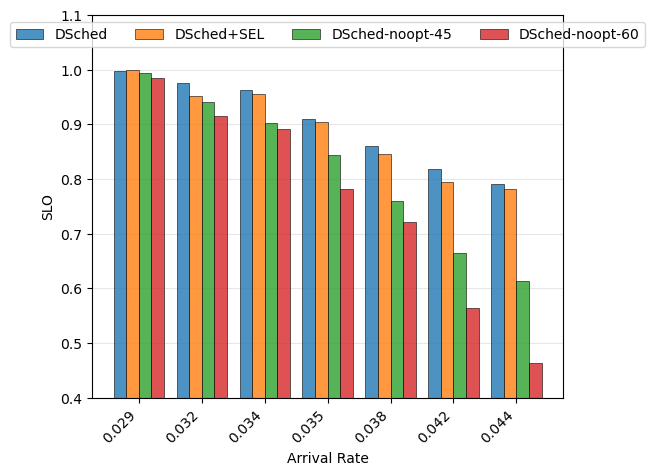

In [16]:
fig, axs = plt.subplots()
boxplot = grouped_bar(
    axs,
    {
        "DSched": [r.slo for r in dsched_results],
        "DSched+SEL": [r.slo for r in dsched_sel_results],
        "DSched-noopt-45": [r.slo for r in dsched_noopt_45_results],
        "DSched-noopt-60": [r.slo for r in dsched_noopt_results],
    },
    [f"{r.arrival_rate:.3f}" for r in dsched_results],
    x_label="Arrival Rate",
    y_label="SLO",
)
axs.set_ylim(bottom=0.4, top=1.1)
plt.show()

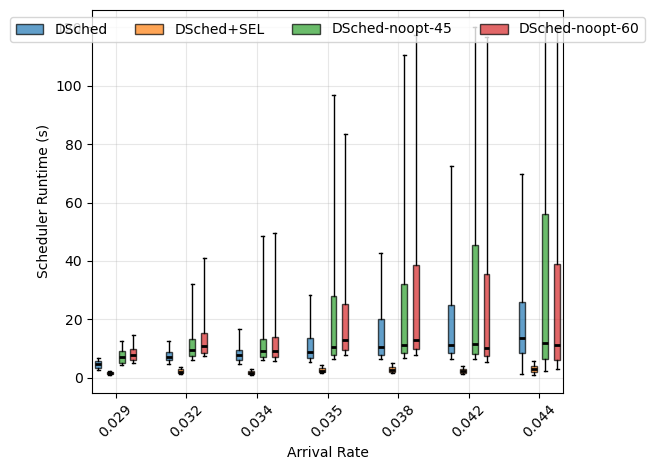

In [17]:
fig, axs = plt.subplots()
boxplot = grouped_boxplot(
    axs,
    {
        "DSched": [r.scheduler_runtimes for r in dsched_results],
        "DSched+SEL": [r.scheduler_runtimes for r in dsched_sel_results],
        "DSched-noopt-45": [r.scheduler_runtimes for r in dsched_noopt_45_results],
        "DSched-noopt-60": [r.scheduler_runtimes for r in dsched_noopt_results],
    },
    [f"{r.arrival_rate:.3f}" for r in dsched_results],
    x_label="Arrival Rate",
    y_label="Scheduler Runtime (s)"
)
plt.show()

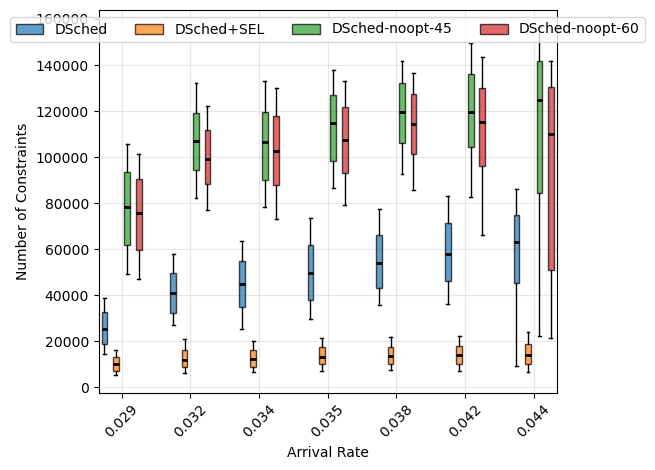

In [18]:
fig, axs = plt.subplots()
boxplot = grouped_boxplot(
    axs,
    {
        "DSched": [r.num_constraints for r in dsched_results],
        "DSched+SEL": [r.num_constraints for r in dsched_sel_results],
        "DSched-noopt-45": [r.num_constraints for r in dsched_noopt_45_results],
        "DSched-noopt-60": [r.num_constraints for r in dsched_noopt_results],
    },
    [f"{r.arrival_rate:.3f}" for r in dsched_results],
    x_label="Arrival Rate",
    y_label="Number of Constraints"
)
plt.show()

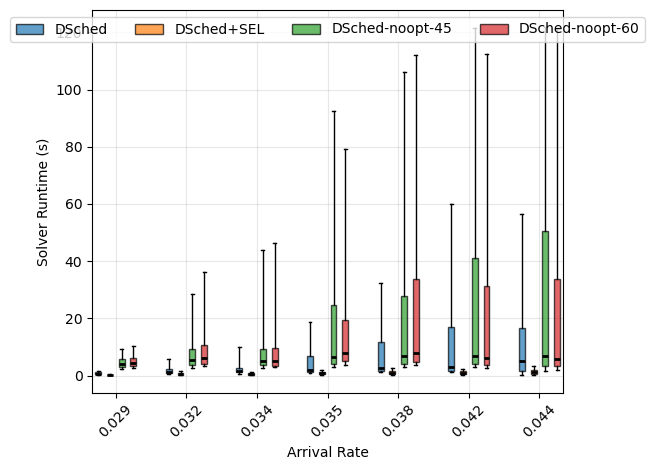

In [19]:
fig, axs = plt.subplots()
boxplot = grouped_boxplot(
    axs,
    {
        "DSched": [r.solver_time_s for r in dsched_results],
        "DSched+SEL": [r.solver_time_s for r in dsched_sel_results],
        "DSched-noopt-45": [r.solver_time_s for r in dsched_noopt_45_results],
        "DSched-noopt-60": [r.solver_time_s for r in dsched_noopt_results],
    },
    [f"{r.arrival_rate:.3f}" for r in dsched_results],
    x_label="Arrival Rate",
    y_label="Solver Runtime (s)"
)
plt.show()